### Import packages


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
import pickle
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, log_loss
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
from keras.applications.mobilenet import MobileNet
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import LeakyReLU
import json
import gc

np.random.seed(2020)
random_state = 52
CATEGORIES = ["c0","c1","c2","c3","c4","c5","c6","c7","c8","c9"]
PATH_COLAB = "/content/drive/My Drive/Deep Learning Project/progetto/"

TensorFlow 1.x selected.


Using TensorFlow backend.


### Definition of functions

In [0]:
def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

def preprocessing(X, Y, img_rows, img_cols, color_type=3):
    
    Y = np.array(Y, dtype=np.uint8)

    if color_type == 1:
        X = np.array(X, dtype=np.uint8).reshape(-1, img_rows, img_cols, 1)
    else:
        X = np.array(X, dtype=np.uint8).reshape(-1, img_rows, img_cols, 3)

    Y = to_categorical(Y, 10)
    X = X.astype('float32')
    X /= 255
    
    return X, Y

In [0]:
def fine_tuning_mobile_net(img_rows, img_cols, color_type, base_model):

    model = Sequential()

    model.add(base_model)

    model.add(Flatten())

    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(10, activation = 'softmax'))

    model.summary()

    model.compile(optimizer = "SGD", loss='categorical_crossentropy', metrics = ["accuracy"])

    return model

In [0]:
def training_model(img_rows, img_cols, color_type=3):
    
    df = pd.DataFrame(columns=['k', 'accuracy', 'log_loss', 'architecture'])
    batch_size = 32
    epochs = 20
    sum_score_acc = 0
    sum_score_log_loss = 0

    name_model = 'mobilenet'

    for k in range(1,6):

        print("\n\nFold " + str(k) + ' out of 5')

        X_train, Y_train, X_val, Y_val = restore_data(PATH_COLAB + "data/k_" + str(k) + ".dat")
        X_train, Y_train = preprocessing(X_train, Y_train, img_rows, img_cols, color_type)
        X_val, Y_val = preprocessing(X_val, Y_val, img_rows, img_cols, color_type)

        datagen = ImageDataGenerator(
          height_shift_range=0.5, 
          width_shift_range = 0.5, 
          zoom_range = 0.5, 
          rotation_range=20 
        )

        data_generator = datagen.flow(X_train, Y_train, batch_size = 32)

        mobilenet = MobileNet(weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, color_type))
        model = fine_tuning_mobile_net(img_rows, img_cols, color_type, mobilenet)

        kfold_weights_path = os.path.join(PATH_COLAB + 'architecture/mobilenet', 'weights_kfold_' + str(k) + '.h5')

        if not os.path.isfile(kfold_weights_path) or RESTORE_WEIGHTS == False:
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0)
            ]
            class_weights = class_weight.compute_sample_weight(class_weight='balanced', y=Y_train)
            
            history = model.fit_generator(data_generator, steps_per_epoch = len(X_train) // batch_size, 
                                epochs=epochs, shuffle=True, verbose=0, validation_data=(X_val, Y_val),
                                class_weight=class_weights, callbacks=callbacks)
            
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

            acc = history.history['acc']
            val_acc = history.history['val_acc']
            n_epoch = range(len(acc))
            axes[0].plot(n_epoch, acc, color='mediumseagreen',marker='.', label='training')
            axes[0].plot(n_epoch, val_acc, color='steelblue', marker='.', label='validation')
            axes[0].set_title('Training and validation accuracy')
            axes[0].set_xlabel('epochs')
            axes[0].set_ylabel('accuracy')
            axes[0].legend(loc="lower right")

            loss = history.history['loss']
            val_loss = history.history['val_loss']
            axes[1].plot(n_epoch, loss, color='mediumseagreen',marker='.', label='training')
            axes[1].plot(n_epoch, val_loss, color='steelblue', marker='.', label='validation')
            axes[1].set_title('Training and validation loss')
            axes[1].set_xlabel('epochs')
            axes[1].set_ylabel('loss')
            axes[1].legend(loc="upper right")

            fig.tight_layout()
            plt.show()
          
        if os.path.isfile(kfold_weights_path):
            model.load_weights(kfold_weights_path)

        predictions_val = model.predict(X_val, batch_size=batch_size, verbose=1)

        predictions_val_arg = [y.argmax() for y in predictions_val]
        Y_val_arg = [y.argmax() for y in Y_val]

        predictions_val_arg = np.array(predictions_val_arg)  
        Y_val_arg = np.array(Y_val_arg)

        score_acc = accuracy_score(Y_val_arg, predictions_val_arg)
        score_log_loss = log_loss(Y_val, predictions_val)
        
        print('Score Accuracy: ', score_acc)
        print('Score Log Loss: ', score_log_loss)

        sum_score_acc += score_acc*X_val.shape[0]
        sum_score_log_loss += score_log_loss*X_val.shape[0]

        print(classification_report(Y_val_arg, predictions_val_arg, target_names=CATEGORIES))

        df = df.append({'k': k, 'accuracy':score_acc, 'log_loss':score_log_loss, 'architecture':name_model}, ignore_index=True)
    
    score_acc = sum_score_acc/(X_train.shape[0] + X_val.shape[0])
    print("Avg Accuracy train indipendent: ", score_acc)

    score_log_loss = sum_score_log_loss/(X_train.shape[0] + X_val.shape[0])
    print("Avg Log Loss train indipendent: ", score_log_loss)

    df['weighted_mean_loss'] = score_log_loss
    df['weighted_mean_acc'] = score_acc

    df.to_csv(PATH_COLAB+'dataframes/'+name_model+'.csv')

    return df

In [0]:
RESTORE_WEIGHTS = False

### MobileNet_trainable_all
It refers to the architecture where all the
blocks and the extra_layers are trained together



Fold 1 out of 5











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2097280   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)   

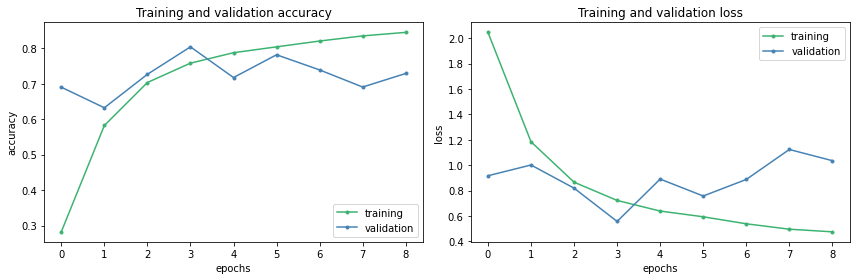

4703/4703 [==============================] - 5s 1ms/step
Score Accuracy:  0.8041675526259834
Score Log Loss:  0.5564977405668183
              precision    recall  f1-score   support

          c0       0.87      0.29      0.44       455
          c1       0.98      0.83      0.90       466
          c2       1.00      0.86      0.92       515
          c3       0.98      0.94      0.96       487
          c4       0.89      0.96      0.92       500
          c5       1.00      0.76      0.86       498
          c6       0.95      0.81      0.88       483
          c7       0.76      0.94      0.84       425
          c8       0.64      0.81      0.71       416
          c9       0.43      0.82      0.57       458

    accuracy                           0.80      4703
   macro avg       0.85      0.80      0.80      4703
weighted avg       0.86      0.80      0.81      4703



Fold 2 out of 5
Model: "sequential_2"
_________________________________________________________________
Layer 

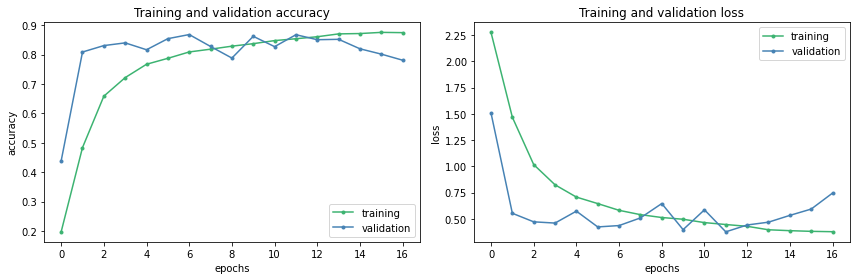

5303/5303 [==============================] - 6s 1ms/step
Score Accuracy:  0.8674335281915897
Score Log Loss:  0.3759008785143149
              precision    recall  f1-score   support

          c0       0.76      0.60      0.67       637
          c1       1.00      0.87      0.93       534
          c2       0.99      0.96      0.98       518
          c3       0.98      1.00      0.99       554
          c4       1.00      0.99      0.99       529
          c5       1.00      0.80      0.89       534
          c6       0.87      0.97      0.92       541
          c7       0.93      1.00      0.96       459
          c8       0.82      0.84      0.83       440
          c9       0.53      0.73      0.61       557

    accuracy                           0.87      5303
   macro avg       0.89      0.87      0.88      5303
weighted avg       0.88      0.87      0.87      5303



Fold 3 out of 5
Model: "sequential_3"
_________________________________________________________________
Layer 

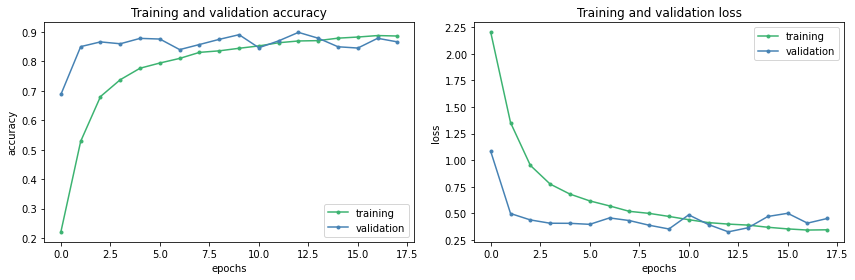

3932/3932 [==============================] - 6s 1ms/step
Score Accuracy:  0.8980162767039674
Score Log Loss:  0.3264314093587453
              precision    recall  f1-score   support

          c0       0.79      0.93      0.86       419
          c1       0.98      0.95      0.96       409
          c2       0.99      0.92      0.96       409
          c3       1.00      0.94      0.97       410
          c4       0.99      0.98      0.98       413
          c5       0.98      0.93      0.96       414
          c6       0.94      0.78      0.86       416
          c7       0.91      0.98      0.95       378
          c8       0.61      0.86      0.71       317
          c9       0.84      0.67      0.74       347

    accuracy                           0.90      3932
   macro avg       0.90      0.89      0.89      3932
weighted avg       0.91      0.90      0.90      3932



Fold 4 out of 5
Model: "sequential_4"
_________________________________________________________________
Layer 

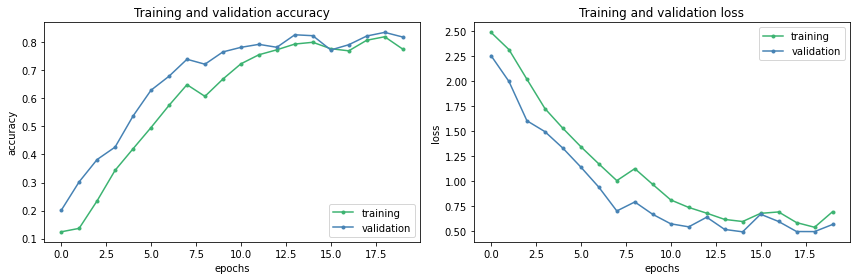

4310/4310 [==============================] - 7s 2ms/step
Score Accuracy:  0.8232018561484918
Score Log Loss:  0.4892055205660424
              precision    recall  f1-score   support

          c0       0.84      0.41      0.55       501
          c1       0.91      0.83      0.87       408
          c2       0.90      0.95      0.92       429
          c3       0.89      0.96      0.92       459
          c4       0.91      0.93      0.92       437
          c5       0.77      0.98      0.86       452
          c6       0.97      0.85      0.91       435
          c7       0.82      0.93      0.87       402
          c8       0.88      0.74      0.80       376
          c9       0.49      0.69      0.57       411

    accuracy                           0.82      4310
   macro avg       0.84      0.83      0.82      4310
weighted avg       0.84      0.82      0.82      4310



Fold 5 out of 5
Model: "sequential_5"
_________________________________________________________________
Layer 

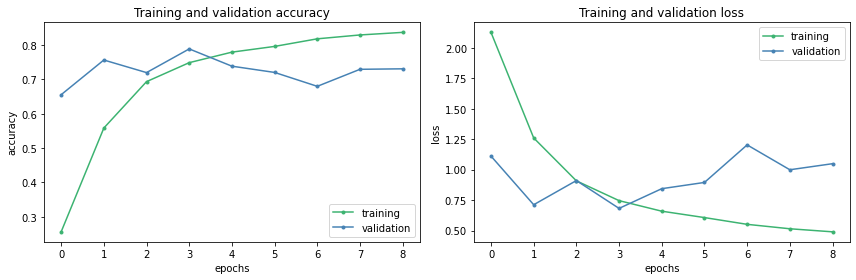

4176/4176 [==============================] - 7s 2ms/step
Score Accuracy:  0.7890325670498084
Score Log Loss:  0.6820703582960981
              precision    recall  f1-score   support

          c0       0.80      0.58      0.67       477
          c1       0.99      0.86      0.92       450
          c2       0.99      0.80      0.88       446
          c3       0.99      0.86      0.92       436
          c4       0.91      0.72      0.80       447
          c5       0.99      0.99      0.99       414
          c6       0.90      0.66      0.76       450
          c7       0.75      0.91      0.82       338
          c8       0.37      0.83      0.51       362
          c9       0.70      0.74      0.72       356

    accuracy                           0.79      4176
   macro avg       0.84      0.79      0.80      4176
weighted avg       0.85      0.79      0.80      4176

Avg Accuracy train indipendent:  0.8364252586514449
Avg Log Loss train indipendent:  0.48389855262798315


,k,accuracy,log_loss,architecture,weighted_mean_loss,weighted_mean_acc
0,1,0.804168,0.556498,mobilenet,0.483899,0.836425
1,2,0.867434,0.375901,mobilenet,0.483899,0.836425
2,3,0.898016,0.326431,mobilenet,0.483899,0.836425
3,4,0.823202,0.489206,mobilenet,0.483899,0.836425
4,5,0.789033,0.682070,mobilenet,0.483899,0.836425


In [0]:
training_model(128,128,3)